In [2]:
import numpy as np 
import new_model
import pandas as pd 
import timeit
import statsmodels.api as sm
import os
from collections import defaultdict
from sklearn.externals import joblib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Activation
from scipy.fftpack import fft,ifft
from statsmodels.tsa.ar_model import AR
import result
from process_data import generate_train_test_data,save_into_csv,get_files_list
from new_model import get_bayes_model,get_svr_model,get_arima_forecast,get_lstm_model,train_lstm,lstm_predict
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# 0. Load Data

In [3]:
df = pd.read_csv("processed_data/max_mem_usage.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14415 entries, 0 to 14414
Columns: 839 entries, 6283034177-660405 to 6282507089-1095473
dtypes: float64(839)
memory usage: 92.3 MB


In [4]:
path = "max_mem_usage"
path1= path + '.csv'
lag = 8
data = generate_train_test_data(0.8, path1, lag)

<<<<<<<<<<<<<<<get the data from the file: max_mem_usage.csv


In [5]:
([x_train, y_train], [x_test, y_test], id_name) = data['max_mem_usage.csv']
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
print('Number of training samples:', len(x_train))
print('Number of testing samples:', len(x_test))

Number of training samples: 823674
Number of testing samples: 206538


# 1. LSTM Prediction Model

In [8]:
# Model construct
model = Sequential()
model.add(LSTM(input_shape=(None,1), units=100, return_sequences=False))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Model training
model = train_lstm(model, x_train, y_train, path, lag, 32, 0.1)

Train on 741306 samples, validate on 82368 samples
Epoch 1/3
741306/741306 [==============================] - 889s 1ms/step - loss: 2.1054e-05 - val_loss: 2.1501e-05
Epoch 2/3
741306/741306 [==============================] - 869s 1ms/step - loss: 1.4720e-05 - val_loss: 1.5301e-05
Epoch 3/3
741306/741306 [==============================] - 847s 1ms/step - loss: 1.3906e-05 - val_loss: 1.3846e-05


In [11]:
# Model prediction
key = "max_mem_usage"
model = load_model('max_mem_usage_lstm_model.h5', compile=False)
if not os.path.exists('new_result1'):
    os.makedirs('new_result1')
for x, y_t, id_name_str in zip(x_test, y_test, id_name):
    start = timeit.default_timer()
    x = x.reshape(1,lag,1)
    y = lstm_predict(x,model)
    spend = timeit.default_timer() - start
    acc = 1- abs((y[0] - y_t)/(y_t + 0.5))
    if acc>0:
        acc = 1- abs((y[0] - y_t)/1)
    with open('new_result1/'+id_name_str+'_acc.txt', 'a+') as f1:
        f1.write(str(acc[0])+'\n')
    with open('new_result1/'+id_name_str+'_time.txt', 'a+') as f2:
        f2.write(str(spend)+'\n')
    with open('new_result1/'+id_name_str+'_pred.txt', 'a+') as f2:
        f2.write(str(y[0][0])+'\n')

In [12]:
# combine files
acc = pd.DataFrame()
time = pd.DataFrame()
pred = pd.DataFrame()

files = os.listdir('new_result1')
for file in files:
    if '_' in file:
        id_name_str = file.split('_')[0]
        file_type = file.split('_')[1]
        cur_df = pd.read_csv('new_result1/'+file, header=None, index_col=False)
        cur_df.columns = [id_name_str]
        if file_type[:3] == 'acc':
            acc = pd.concat([acc, cur_df], axis=1)
        elif file_type[:4] == 'time':
            time = pd.concat([time, cur_df], axis=1)
        elif file_type[:4] == 'pred':
            pred = pd.concat([pred, cur_df], axis=1)

acc.to_csv('new_result/max_mem_usage_lstm_acc.csv', index=False)
time.to_csv('new_result/max_mem_usage_lstm_time.csv', index=False)
pred.to_csv('new_result/max_mem_usage_lstm_pred.csv', index=False)
print('<<<<<<<<<<<<<<< Save predictions !!!')

<<<<<<<<<<<<<<< Save predictions !!!


# 2. FFT Prediction Model

In [13]:
def FFT(data, lag):
    for i in range(lag):
        fk_list = []
        for k in range(lag):
            fk_list.append(fft(data[k]))
        pn = 0.
        for k in range(lag//2):
            xx = ifft(fk_list[k]).real
            first_half = xx[:lag//2].sum()
            pn += first_half/lag
        pred = pn 
    return pred

In [14]:
key = "long_term_maximum_CPU_usage"
N = x_test.shape[0]
if not os.path.exists('new_result2'):
    os.makedirs('new_result2')
for i in range(lag, N-lag-1):
    start = timeit.default_timer()
    x = x_test[i-lag:i] # 8 x 8
    y = FFT(x, lag) # 1
    spend = timeit.default_timer() - start
    acc = 1- abs((y - y_test[i])/(y_test[i] + 0.1))
    with open('new_result2/'+id_name[i]+'_acc.txt', 'a+') as f1:
        f1.write(str(acc)+'\n')
    with open('new_result2/'+id_name[i]+'_time.txt', 'a+') as f2:
        f2.write(str(spend)+'\n')
    with open('new_result2/'+id_name[i]+'_pred.txt', 'a+') as f2:
        f2.write(str(y)+'\n')

In [15]:
# combine files
acc = pd.DataFrame()
time = pd.DataFrame()
pred = pd.DataFrame()

files = os.listdir('new_result2')
for file in files:
    if '_' in file:
        id_name_str = file.split('_')[0]
        file_type = file.split('_')[1]
        cur_df = pd.read_csv('new_result2/'+file, header=None, index_col=False)
        cur_df.columns = [id_name_str]
        if file_type[:3] == 'acc':
            acc = pd.concat([acc, cur_df], axis=1)
        elif file_type[:4] == 'time':
            time = pd.concat([time, cur_df], axis=1)
        elif file_type[:4] == 'pred':
            pred = pd.concat([pred, cur_df], axis=1)

acc.to_csv('new_result/max_mem_usage_fft_acc.csv', index=False)
time.to_csv('new_result/max_mem_usage_fft_time.csv', index=False)
pred.to_csv('new_result/max_mem_usage_fft_pred.csv', index=False)
print('<<<<<<<<<<<<<<< Save predictions !!!')

<<<<<<<<<<<<<<< Save predictions !!!


# 3. Improved FFT Prediction Model

In [16]:
def Improved_FFT(data, rn_train, lag):
    for i in range(lag):
        fk_list = []
        for k in range(lag):
            fk_list.append(fft(data[k]))
        pn, rn = 0., 0.
        for k in range(lag//2):
            xx = ifft(fk_list[k]).real
            first_half = xx[:lag//2].sum()
            pn += first_half/lag
            second_half = xx[lag//2:].sum()
            rn += second_half/lag
        rn_train.append(rn)
        if len(rn_train) == lag:
            model_ar2 = AR(np.array(rn_train))
            res_ar2 = model_ar2.fit(trend='nc')
            pred_rn = res_ar2.predict(start=lag, end=lag+1, dynamic=True)[-1]
            rn_train.pop(0)
        else:
            pred_rn = 0.
        pred = pn + pred_rn
    return pred, rn_train

In [17]:
key = "long_term_maximum_CPU_usage"
rn_train = []
N = x_test.shape[0]
if not os.path.exists('new_result3'):
    os.makedirs('new_result3')
for i in range(lag, N-lag-1):
    start = timeit.default_timer()
    x = x_test[i-lag:i] # 8 x 8
    y, rn_train = Improved_FFT(x, rn_train, lag) # 1
    spend = timeit.default_timer() - start
    acc = 1- abs((y - y_test[i])/(y_test[i] + 0.5))
    with open('new_result3/'+id_name[i]+'_acc.txt', 'a+') as f1:
        f1.write(str(acc)+'\n')
    with open('new_result3/'+id_name[i]+'_time.txt', 'a+') as f2:
        f2.write(str(spend)+'\n')
    with open('new_result3/'+id_name[i]+'_pred.txt', 'a+') as f2:
        f2.write(str(y)+'\n')

In [18]:
# combine files
acc = pd.DataFrame()
time = pd.DataFrame()
pred = pd.DataFrame()

files = os.listdir('new_result3')
for file in files:
    if '_' in file:
        id_name_str = file.split('_')[0]
        file_type = file.split('_')[1]
        cur_df = pd.read_csv('new_result3/'+file, header=None, index_col=False)
        cur_df.columns = [id_name_str]
        if file_type[:3] == 'acc':
            acc = pd.concat([acc, cur_df], axis=1)
        elif file_type[:4] == 'time':
            time = pd.concat([time, cur_df], axis=1)
        elif file_type[:4] == 'pred':
            pred = pd.concat([pred, cur_df], axis=1)

acc.to_csv('new_result/max_mem_usage_improved_fft_acc.csv', index=False)
time.to_csv('new_result/max_mem_usage_improved_fft_time.csv', index=False)
pred.to_csv('new_result/max_mem_usage_improved_fft_pred.csv', index=False)

# 4. Prediction Accuracy Comparision

In [19]:
df_lstm = pd.read_csv('new_result/max_mem_usage_lstm_acc.csv')
df_fft = pd.read_csv('new_result/max_mem_usage_fft_acc.csv')
df_ifft = pd.read_csv('new_result/max_mem_usage_improved_fft_acc.csv')

In [20]:
data_value=[]
for data_column in df_lstm.columns:
    temp = df_lstm[data_column].dropna() 
    for i in range(temp.shape[0]):
        if temp[i]>0:
            data_value.append(temp[i])
data_value2=[]
for data_column in df_fft.columns:
    temp = df_fft[data_column].dropna() 
    for i in range(temp.shape[0]):
        if temp[i]>0:
            data_value2.append(temp[i])
data_value3=[]
for data_column in df_ifft.columns:
    temp = df_ifft[data_column].dropna() 
    for i in range(temp.shape[0]):
        if temp[i]>0:
            data_value3.append(temp[i])

In [32]:
from scipy import stats
res1 = stats.relfreq(data_value, numbins=25)
y1 = np.cumsum(res1.frequency)
x1 = res1.lowerlimit + np.linspace(0, res1.binsize*res1.frequency.size,res1.frequency.size)

res2 = stats.relfreq(data_value2, numbins=25)
y2 = np.cumsum(res2.frequency)
x2 = res2.lowerlimit + np.linspace(0, res2.binsize*res1.frequency.size,res2.frequency.size)

res3 = stats.relfreq(data_value3, numbins=25)
y3 = np.cumsum(res3.frequency)
x3 = res3.lowerlimit + np.linspace(0, res3.binsize*res1.frequency.size,res3.frequency.size)

Text(0, 0.5, 'cdf')

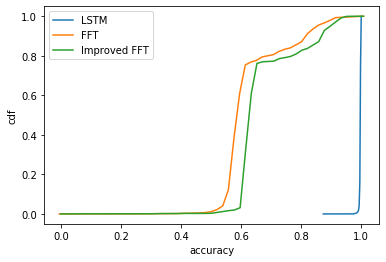

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x1,y1,label='LSTM')
plt.plot(x2,y2,label='FFT')
plt.plot(x3,y3,label='Improved FFT')
plt.legend()
plt.xlabel('accuracy')
plt.ylabel('cdf')

# 5. Time overhead Comparision

In [23]:
tm = pd.read_csv('new_result/max_mem_usage_lstm_time.csv')
time_fft = pd.read_csv('new_result/max_mem_usage_fft_time.csv')
time_ifft = pd.read_csv('new_result/max_mem_usage_improved_fft_time.csv')

In [24]:
time_value=[]
for time_column in tm.columns:
    temp = tm[time_column].dropna() 
    for i in range(temp.shape[0]):
        if temp[i]>0:
            time_value.append(temp[i])
time_value2=[]
for data_column in time_fft.columns:
    temp = time_fft[data_column].dropna() 
    for i in range(temp.shape[0]):
        if temp[i]>0:
            time_value2.append(temp[i])
time_value3=[]
for data_column in time_ifft.columns:
    temp = time_ifft[data_column].dropna() 
    for i in range(temp.shape[0]):
        if temp[i]>0:
            time_value3.append(temp[i])

In [25]:
time_average_lstm= sum(time_value)/len(time_value)
time_average_fft= sum(time_value2)/len(time_value2)
time_average_ifft= sum(time_value3)/len(time_value3)
time_overhead=[time_average_fft, time_average_ifft, time_average_lstm]

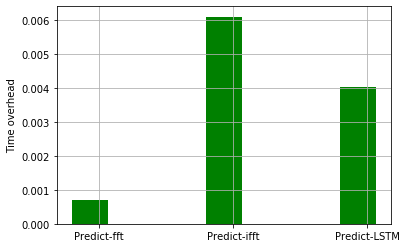

In [26]:
def draw_bar(labels,quants,name):
    width = 0.4
    ind = np.linspace(0,3,3)
    # make a square figure
    fig = plt.figure(1)
    ax  = fig.add_subplot(111)
    # Bar Plot
    ax.bar(ind-width/4,quants,width,color='green')
    # Set the ticks on x-axis
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    # labels
    #ax.set_xlabel()
    ax.set_ylabel(name)
    # title
    #ax.set_title('Top 10 GDP Countries', bbox={'facecolor':'0.8', 'pad':5})
    plt.grid(True)
    plt.show()
    plt.savefig("Predict_Method.jpg")
    plt.close()
 
labels = ['Predict-fft', 'Predict-ifft','Predict-LSTM']
 
quants = time_overhead
 
draw_bar(labels,quants,"Time overhead")